In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.layers import Bidirectional, GlobalMaxPool1D,Conv1D
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras import callbacks
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow

import pandas as pd
import numpy as np

import json
import time
import os
import gc
import collections

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [103]:
pd.options.display.max_rows = 10
pd.options.display.max_columns = 42

### Load Datasets

#### Load "Text+Ratings.csv" (dataset_1)

In [3]:
# Load dataset and print info
text_and_ratings=pd.read_csv("Text+Ratings.csv",
                            usecols=["text","stars"])
print ("Text+Ratings Length: ", len(text_and_ratings))
print ("Text+Ratings Dtypes:\n", text_and_ratings.dtypes)
print ("Text+Ratings Labels: ", text_and_ratings.stars.unique())

Text+Ratings Length:  500001
Text+Ratings Dtypes:
 stars    float64
text      object
dtype: object
Text+Ratings Labels:  [ 4.  5.  2.  1.  3. nan]


In [4]:
# Drop NaNs and convert types
text_and_ratings.dropna(inplace=True)
text_and_ratings = text_and_ratings.astype({'stars': np.int8})
print ("Text+Ratings Length: ", len(text_and_ratings))
print ("Text+Ratings Dtypes:\n", text_and_ratings.dtypes)
print ("Text+Ratings Labels: ", text_and_ratings.stars.unique())

Text+Ratings Length:  500000
Text+Ratings Dtypes:
 stars      int8
text     object
dtype: object
Text+Ratings Labels:  [4 5 2 1 3]


#### Load "Text+Business.csv" (dataset_2)

In [5]:
# Load dataset and print info
text_and_business=pd.read_csv("Text+Business.csv",
                            usecols=["text","business_id"])
print ("Text+Business Length: ", len(text_and_business))

Text+Business Length:  996996


In [6]:
# Drop NaNs
text_and_business.dropna(inplace=True)
print ("Text+Business Length: ", len(text_and_business))

Text+Business Length:  996995


In [7]:
# Get some insight on its labels
business_dist = text_and_business.business_id.value_counts()
business_dist

4JNXUYY8wbaaDmk3BPzlWw    1308
RESDUcs7fIiihp38-d6_6g    1278
K7lWdNUhCbcnEvI0NhGewg    1123
cYwJA2A6I12KNkm2rtXd5g     938
f4x1YBxkLrZg652xt2KR5g     897
                          ... 
ziAwyzwgQGYgJmCae042gw       1
2KxxZnzvTP3lrtgU71tk5g       1
v3Y3btCs-JyDR1u806otvA       1
6BCBUPgyD7aVtMwUWdcRZA       1
mdEkl6kDxMrg-n5s6y6Zhw       1
Name: business_id, Length: 141627, dtype: int64

In [8]:
# Limit number of labels
MAX_NUMBER_BUSINESS = 100
top_business_dist = text_and_business.business_id.value_counts()[:MAX_NUMBER_BUSINESS]
bottom_business_dist = text_and_business.business_id.value_counts()[MAX_NUMBER_BUSINESS:]
display(top_business_dist)
display(bottom_business_dist)

4JNXUYY8wbaaDmk3BPzlWw    1308
RESDUcs7fIiihp38-d6_6g    1278
K7lWdNUhCbcnEvI0NhGewg    1123
cYwJA2A6I12KNkm2rtXd5g     938
f4x1YBxkLrZg652xt2KR5g     897
                          ... 
ugLqbAvBdRDc-gS4hpslXw     305
Xg5qEQiB-7L6kGJ5F4K3bQ     303
yNPh5SO-7wr8HPpVCDPbXQ     301
BIBWGO_r_1znnlmLbp4Nxg     300
QJR4qBUHegWEozSQrGmBPw     299
Name: business_id, Length: 100, dtype: int64

yQab5dxZzgBLTEHCw9V7_w    298
_w5hBpkjHs5_Hv3pLeHtIw    289
L2p0vO3fsS2LC6hhQo3CzA    288
wUKzaS1MHg94RGM6z8u9mw    286
p0iEUamJVp_QpaheE-Nz_g    286
                         ... 
ziAwyzwgQGYgJmCae042gw      1
2KxxZnzvTP3lrtgU71tk5g      1
v3Y3btCs-JyDR1u806otvA      1
6BCBUPgyD7aVtMwUWdcRZA      1
mdEkl6kDxMrg-n5s6y6Zhw      1
Name: business_id, Length: 141527, dtype: int64

In [9]:
# Relabel least frequent labels to "OTHERS"
relabeled_text_and_business = text_and_business.copy()
relabeled_text_and_business['business_id'][relabeled_text_and_business['business_id'].isin(bottom_business_dist.index)] = "OTHERS"
relabeled_business_dist = relabeled_text_and_business.business_id.value_counts()
relabeled_business_dist

OTHERS                    950761
4JNXUYY8wbaaDmk3BPzlWw      1308
RESDUcs7fIiihp38-d6_6g      1278
K7lWdNUhCbcnEvI0NhGewg      1123
cYwJA2A6I12KNkm2rtXd5g       938
                           ...  
ugLqbAvBdRDc-gS4hpslXw       305
Xg5qEQiB-7L6kGJ5F4K3bQ       303
yNPh5SO-7wr8HPpVCDPbXQ       301
BIBWGO_r_1znnlmLbp4Nxg       300
QJR4qBUHegWEozSQrGmBPw       299
Name: business_id, Length: 101, dtype: int64

In [10]:
# Drop samples of "OTHERS" to make the dataset more balanced
drop_frac = (1 - 2*float(relabeled_business_dist[1]) / relabeled_business_dist[0])
resampled_text_and_business = relabeled_text_and_business.drop(relabeled_text_and_business[relabeled_text_and_business['business_id'] == 'OTHERS'].sample(frac=drop_frac).index)
print("Length of dataset after drops", len(resampled_text_and_business))
resampled_text_and_business.business_id.value_counts()

Length of dataset after drops 48850


OTHERS                    2616
4JNXUYY8wbaaDmk3BPzlWw    1308
RESDUcs7fIiihp38-d6_6g    1278
K7lWdNUhCbcnEvI0NhGewg    1123
cYwJA2A6I12KNkm2rtXd5g     938
                          ... 
ugLqbAvBdRDc-gS4hpslXw     305
Xg5qEQiB-7L6kGJ5F4K3bQ     303
yNPh5SO-7wr8HPpVCDPbXQ     301
BIBWGO_r_1znnlmLbp4Nxg     300
QJR4qBUHegWEozSQrGmBPw     299
Name: business_id, Length: 101, dtype: int64

#### Load "Text+Rating+Business.csv" (dataset_3)

In [11]:
# Text+Rating+Business
text_and_rating_and_business=pd.read_csv("Text+Rating+Business.csv",
                            usecols=["text","stars","business_id"])
print ("Text+Rating+Business Length: ", len(text_and_rating_and_business))
# Drop NaNs
text_and_rating_and_business.dropna(inplace=True)
print ("Text+Rating+Business Length: ", len(text_and_rating_and_business))
# Insight Labels
rating_and_business_dist = text_and_rating_and_business.business_id.value_counts()
rating_and_business_dist

Text+Rating+Business Length:  5000
Text+Rating+Business Length:  5000


cYwJA2A6I12KNkm2rtXd5g    147
KskYqH1Bi7Z_61pH6Om8pg    116
rcaPajgKOJC2vo_l3xa42A    108
SMPbvZLSMMb7KU76YNYMGg    107
2weQS-RnoOBhb1KsHKyoSQ    102
                         ... 
WbJ1LRQdOuYYlRLyTkuuxw     28
u-SJ5QUwrNquL9VnXwl8cg     28
gTlDDzDEHyDQ6iwjNhpI6A     28
fHM09_y3QX3n4a_bIFbk_w     26
pHJu8tj3sI8eC5aIHLFEfQ     24
Name: business_id, Length: 100, dtype: int64

In [12]:
## Relabaling of the dataset
relabeled_text_and_rating_and_business = text_and_rating_and_business.copy()
# Change to OTHERS the business_id that we have not seen before
relabeled_text_and_rating_and_business['business_id'][~relabeled_text_and_rating_and_business['business_id'].isin(business_dist.index)] = "OTHERS"
# Change to OTHERS the business_id that we have seen but are from the least frequent ones
relabeled_text_and_rating_and_business['business_id'][relabeled_text_and_rating_and_business['business_id'].isin(bottom_business_dist.index)] = "OTHERS"
relabeled_text_and_rating_and_business_dist = relabeled_text_and_rating_and_business.business_id.value_counts()
relabeled_text_and_rating_and_business_dist


/home/maxi/.virtualenvs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/maxi/.virtualenvs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


OTHERS                    2163
cYwJA2A6I12KNkm2rtXd5g     147
KskYqH1Bi7Z_61pH6Om8pg     116
rcaPajgKOJC2vo_l3xa42A     108
SMPbvZLSMMb7KU76YNYMGg     107
                          ... 
Fi-2ruy5x600SX4avnrFuA      47
r_BrIgzYcwo1NAuG9dLbpg      45
9a3DrZvpYxVs3k_qwlCNSw      43
kRgAf6j2y1eR0wOFdzFAuw      43
Xg5qEQiB-7L6kGJ5F4K3bQ      43
Name: business_id, Length: 42, dtype: int64

In [13]:
# Drop samples of "OTHERS" to make the dataset more balanced
drop_frac = (1 - 2*float(relabeled_text_and_rating_and_business_dist[1]) / relabeled_text_and_rating_and_business_dist[0])
resampled_text_and_rating_and_business = relabeled_text_and_rating_and_business.drop(relabeled_text_and_rating_and_business[relabeled_text_and_rating_and_business['business_id'] == 'OTHERS'].sample(frac=drop_frac).index)
print("Length of dataset after drops", len(resampled_text_and_rating_and_business))
resampled_text_and_rating_and_business.business_id.value_counts()

Length of dataset after drops 3131


OTHERS                    294
cYwJA2A6I12KNkm2rtXd5g    147
KskYqH1Bi7Z_61pH6Om8pg    116
rcaPajgKOJC2vo_l3xa42A    108
SMPbvZLSMMb7KU76YNYMGg    107
                         ... 
Fi-2ruy5x600SX4avnrFuA     47
r_BrIgzYcwo1NAuG9dLbpg     45
9a3DrZvpYxVs3k_qwlCNSw     43
kRgAf6j2y1eR0wOFdzFAuw     43
Xg5qEQiB-7L6kGJ5F4K3bQ     43
Name: business_id, Length: 42, dtype: int64

So, from the 100 businesses selected for the Text+Rating+Business dataset, only 41 are from the top 100 most frequent in the Text+Business dataset.

### Create the inputs and output to train the models

#### Get the texts and labels from the datasets

In [14]:
texts_1 = text_and_ratings["text"].values
ratings_1 = text_and_ratings["stars"].values

texts_2 = resampled_text_and_business["text"].values
business_2 = resampled_text_and_business["business_id"].values

texts_3 = resampled_text_and_rating_and_business["text"].values
ratings_3 = resampled_text_and_rating_and_business["stars"].values
business_3 = resampled_text_and_rating_and_business["business_id"].values

In [15]:
texts = np.concatenate((texts_1, np.concatenate((texts_2, texts_3), axis=0)), axis=0)

#### Create a unique dictionary from the datasets. We will use this to create an embedding layer

In [16]:
MAX_NUM_WORDS=5000 # how many unique words to use (i.e num rows in embedding vector)

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 210792 unique tokens.


#### Convert the strings (inputs) to sequences, and pad them. This is needed to train in mini-batches

In [17]:
sequences_1 = tokenizer.texts_to_sequences(texts_1)
sequences_2 = tokenizer.texts_to_sequences(texts_2)
sequences_3 = tokenizer.texts_to_sequences(texts_3)
sequences = sequences_1.copy()
sequences.extend(sequences_2)
sequences.extend(sequences_3) 

Before we build our dictionary and embedding layer, we should see how may words a texts usually has. So let's plot an hisotogram with that information.

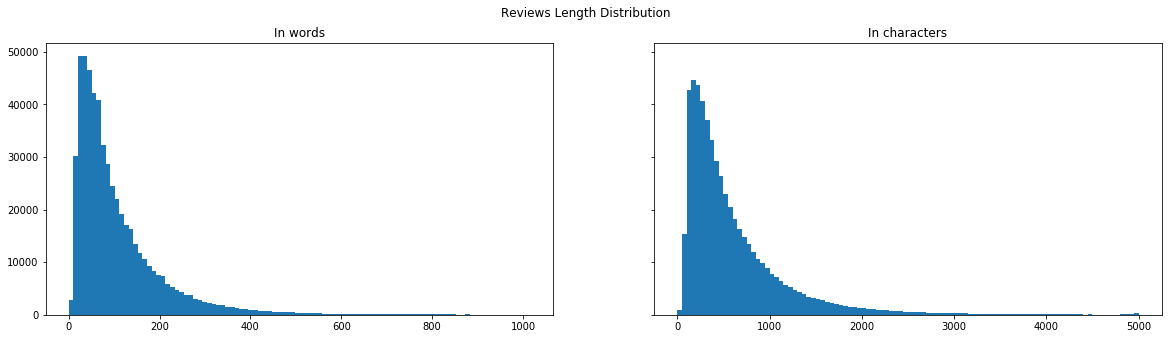

In [18]:
sequences_word_length = [len (sample) for sample in sequences]
texts_ch_length = [len (sample) for sample in texts]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.suptitle('Reviews Length Distribution')
f.set_size_inches((20, 5))
ax1.hist(sequences_word_length, bins=100)
ax1.set_title('In words')
ax2.hist(texts_ch_length, bins=100)
ax2.set_title('In characters')

plt.show()

Using a larger sequence, would mean that we would be truncating less samples, but it would also make the training process slower. So we will be a using a value that could be relatively not bad for both things.

In [19]:
MAX_SEQUENCE_LENGTH=200 # max number of words in a review to use

data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
data_3 = pad_sequences(sequences_3, maxlen=MAX_SEQUENCE_LENGTH)

#### Create the word_to_vec_map from Glove

In [20]:
def loadGloveModel(gloveFile):
    """
    Loads GloVe Model
    
    Arguments:
    gloveFile -- path to the glove file

    Returns:
    embeddings_index -- a word_to_vec_map, where keys are words, and values are vectors (represented by arrays)
    """
    
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    embeddings_index = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        embeddings_index[word] = embedding
    print("Done.",len(embeddings_index)," words loaded!")
    return embeddings_index

In [21]:
word_to_vec_map = loadGloveModel('glove.6B.50d.txt')

Loading Glove Model
Done. 400000  words loaded!


#### Create the embedding_matrix from the word_to_vec_map and our dictionary

In [22]:
emb_dim = word_to_vec_map["hello"].shape[0] # how big is each word vector
vocab_len = len(word_index) + 1

embedding_matrix = np.zeros((vocab_len, emb_dim))

for word, i in word_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

#### Build the embedding_layer

In [23]:
embedding_layer = Embedding(input_dim=vocab_len,
                            output_dim=emb_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedded_sequences = embedding_layer(inp)

#### Convert the ratings and businesses (outputs) to categorical variables

In [24]:
labels_1 = to_categorical(ratings_1, dtype='int8')
labels_1.shape
# 0 is not used

(500000, 6)

In [25]:
text_and_business_hashtable = {y:x for x, y in enumerate(resampled_text_and_business.business_id.unique())}
labels_2 = np.array([text_and_business_hashtable.get(elem) for elem in business_2])
labels_2 = to_categorical(labels_2, num_classes=101, dtype='int8')
labels_2.shape
# 100 + OTHERS

(48850, 101)

In [26]:
labels_3a = to_categorical(ratings_3, num_classes=None, dtype='int8')
labels_3a.shape
# 0 is not used

(3131, 6)

In [27]:
labels_3b = [text_and_business_hashtable.get(elem) for elem in business_3]
labels_3b = to_categorical(labels_3b, num_classes=101, dtype='int8')
labels_3b.shape
# 100 + OTHERS

(3131, 101)

#### Weight labels from dataset_1 and dataset_2 according to their frequency in the samples 

In [28]:
total_weight_per_class = len(labels_1) / 5
sum_labels_1 = labels_1.sum(axis=0).astype(np.float32)
labels_1_weights = total_weight_per_class/sum_labels_1
labels_1_weights[0] = 0
labels_1_weights = dict( zip(range(0,labels_1.shape[1]+1),labels_1_weights ))
labels_1_weights

/home/maxi/.virtualenvs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


{0: 0.0, 1: 1.3878095, 2: 2.4515212, 3: 1.7856187, 4: 0.89981467, 5: 0.4545124}

In [29]:
counter=collections.Counter(np.argmax(labels_2, axis=1))
labels_2_counts = dict(counter).values()
total_weight_per_class = len(labels_2) / 101
labels_2_weights = [total_weight_per_class/ float(x) for x in labels_2_counts]
labels_2_weights = dict( zip(range(0,len(text_and_business_hashtable)+1),labels_2_weights ))

#### Define model class. The hyperparams will be tuned separately for each model

In [54]:
class MyModel(object):
    
    def __init__(self, hyperparams):
        
        # hyperparams is dict that contains the hyperparams of one model
        
        embedding_layer = Embedding(input_dim=vocab_len,
                                    output_dim=emb_dim,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
        inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
        x = embedded_sequences = embedding_layer(inp)
        x = Bidirectional(LSTM(emb_dim, return_sequences=True, dropout=hyperparams["LSTM_DROPOUT"], recurrent_dropout=hyperparams["LSTM_RECURRENT_DROPOUT"]))(x)
        x = GlobalMaxPool1D()(x)
        x = Dense(hyperparams["1_FC_SIZE"], activation="relu")(x)
        x = BatchNormalization(axis=1)(x)
        x = Dropout(hyperparams["1_FC_DROPOUT"])(x)
        x = Dense(hyperparams["2_FC_SIZE"], activation="relu")(x)
        x = BatchNormalization(axis=1)(x)
        x = Dropout(hyperparams["2_FC_DROPOUT"])(x)
        y = Dense(hyperparams["FINAL_SIZE"], activation="softmax")(x)
        self.model = Model(inputs=inp, outputs=y)
        return

    def train(self, train_params, train_data, train_labels, eval_data, eval_labels, labels_weights, checkpoints=False):        
        
        self.train_params = train_params
        
        if checkpoints:
            # using checkpoints
            # include the epoch in the file name. (uses `str.format`)
            checkpoint_path = "./cp-{epoch:04d}.ckpt"
            checkpoint_dir = os.path.dirname(checkpoint_path)
            # Create checkpoint callback
            cp_callback = callbacks.ModelCheckpoint(checkpoint_path,
                                                    save_weights_only=True, # as I know the model architecture, I can save the weights only
                                                    period=1, # every 1 epoch (default)
                                                    verbose=1)
            model_callbacks = [cp_callback]
            self.model.save_weights(checkpoint_path.format(epoch=0))
        else:
            model_callbacks = None

        print ("Training model...")
        start = time.clock()
        self.model.compile(loss='categorical_crossentropy', optimizer='Adamax', weighted_metrics=['categorical_accuracy'])
        self.history = self.model.fit(train_data, train_labels,
                            batch_size=train_params["BATCH_SIZE"], epochs=train_params["NUM_EPOCHS"],
                            shuffle=True, verbose=1,
                            validation_data = (eval_data, eval_labels),
                            class_weight = labels_weights,
                            callbacks=model_callbacks)
        end = time.clock()
        self.train_time = end-start
        print('Time spent: [s]: {:0.0f}'.format(self.train_time))

        print ("Evaluating model...")
        _, self.train_acc = self.model.evaluate(train_data, train_labels, batch_size=train_params["BATCH_SIZE"], verbose=1)
        self.eval_loss, self.eval_acc = self.model.evaluate(eval_data, eval_labels, batch_size=train_params["BATCH_SIZE"], verbose=1)

        return (self.train_acc, self.eval_loss, self.eval_acc, self.train_time)
    
    def print_statistics(self):
        print('Train accuracy [%]: ', (self.train_acc*100))
        print('Eval accuracy [%]: ', (self.eval_acc*100))
        print('Bias [%]: ', ((1-self.train_acc)*100))
        print('Variance [%]: ', (((1-self.eval_acc) - (1-self.train_acc))*100))
        return
    
    def plot_loss(self):
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(np.arange(0, self.train_params["NUM_EPOCHS"]), self.model.history.history["loss"], label="train_loss")
        plt.plot(np.arange(0, self.train_params["NUM_EPOCHS"]), self.model.history.history["val_loss"], label="val_loss")
        plt.title("Training Loss Curves")
        plt.xlabel("Epoch #")
        plt.legend(loc="lower left")
        plt.savefig("loss_plot.png")
        plt.show()
        
    def plot_error(self):
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(np.arange(0, self.train_params["NUM_EPOCHS"]), 100*(1-np.array(self.model.history.history["weighted_categorical_accuracy"])), label="train_error")
        plt.plot(np.arange(0, self.train_params["NUM_EPOCHS"]), 100*(1-np.array(self.model.history.history["val_weighted_categorical_accuracy"])), label="val_error")
        plt.title("Training Error Curves")
        plt.xlabel("Epoch #")
        plt.legend(loc="lower left")
        plt.savefig("loss_plot.png")
        plt.show()

#### Helper class for hyperparameters tuning

In [76]:
class MyTuningStep(object):
    
    def __init__(self):
        return

    # Helper function to clean memory
    def reset_keras(self):
        sess = get_session()
        clear_session()
        sess.close()
        sess = get_session()

        try:
            del classifier # this is from global space - change this as you need
        except:
            pass

        gc.collect()

        # use the same config as you used to create the session
        config = tensorflow.ConfigProto()
        config.gpu_options.per_process_gpu_memory_fraction = 1
        config.gpu_options.visible_device_list = "0"
        set_session(tensorflow.Session(config=config))    
    
    def train_tuning_step_with_holdout(self, train_params, list_of_hyperparams, data, labels, labels_weights, val_split, random_state=None, checkpoints=False):

        num_models = len(list_of_hyperparams)

        self.train_accs = np.zeros((num_models))
        self.eval_losses = np.zeros((num_models))
        self.eval_accs = np.zeros((num_models))
        self.train_times = np.zeros((num_models))

        # Split data/labels in train and eval
        train_data, eval_data, train_labels, eval_labels = train_test_split(data, labels, test_size=val_split, random_state=random_state, stratify=np.argmax(labels, axis=1))

        for i_model in range (num_models):

            print ("MODEL: ", i_model)

            self.reset_keras()
            model = MyModel(list_of_hyperparams[i_model])
            model.model.compile(loss='categorical_crossentropy', optimizer='Adamax', weighted_metrics=['categorical_accuracy'])
            model.model.summary()
            self.train_accs[i_model], self.eval_losses[i_model], self.eval_accs[i_model], self.train_times[i_model] = model.train(train_params, train_data, train_labels, eval_data, eval_labels, labels_weights, checkpoints=checkpoints)

        return (self.train_accs, self.eval_losses, self.eval_accs, self.train_times)
    
    def train_tuning_step_with_kfolds(self, train_params, list_of_hyperparams, data, labels, labels_weights, k_folds, checkpoints=False):

        num_models = len(list_of_hyperparams)
        
        skf = StratifiedKFold(n_splits=k_folds)

        self.train_accs = np.zeros((num_models,k_folds))
        self.eval_losses = np.zeros((num_models,k_folds))
        self.eval_accs = np.zeros((num_models,k_folds))
        self.train_times = np.zeros((num_models,k_folds))

        for i_model in range (num_models):
            print ("MODEL: ", i_model)
            i_fold=0
            for train_index, eval_index in skf.split(data, np.argmax(labels, axis=1)):
                print ("FOLD: ", i_fold)

                train_data, eval_data = data[train_index], data[eval_index]
                train_labels, eval_labels = labels[train_index], labels[eval_index]

                self.reset_keras()
                model = MyModel(list_of_hyperparams[i_model])
                model.model.compile(loss='categorical_crossentropy', optimizer='Adamax', weighted_metrics=['categorical_accuracy'])
                self.train_accs[i_model,i_fold], self.eval_losses[i_model,i_fold], self.eval_accs[i_model,i_fold], self.train_times[i_model,i_fold] = model.train(train_params, train_data, train_labels, eval_data, eval_labels, labels_weights, checkpoints=checkpoints)

                i_fold += 1
                
        self.train_accs = self.train_accs.mean(axis=1)
        self.eval_losses = self.eval_losses.mean(axis=1)
        self.eval_accs = self.eval_accs.mean(axis=1)
        self.train_times = self.train_times.mean(axis=1)       

        return (self.train_accs, self.eval_losses, self.eval_accs, self.train_times)
    
    def print_statistics(self):
        print('Train accuracy [%]: ', (self.train_accs*100))
        print('Eval accuracy [%]: ', (self.eval_accs*100))
        print('Bias [%]: ', ((1-self.train_accs)*100))
        print('Variance [%]: ', (((1-self.eval_accs) - (1-self.train_accs))*100))
        return

### Model 1 (ratings output)

We will be tuning hyperparameters (4 configurations per step) with holdout cross-validation (the test/train split is small, so maybe we don't need to use k-folds) and a small number of epochs (I'm just trying to find which hyperparameters could work better, not to train a final model, so the first epochs give me an idea in a short amount of time). At first, we will not using drop-put (we will add it later if we need to reduce overfitting). We will look at the weighted bias and variance and tune the hyperparameters in next steps to get better results, until we no longer progress that much. Then, using those hyperparameters, we will train one more model with more epochs, and using checkpoints. At the end, we will just keep the checkpoint with the best performance (just before it starts to overfit).

In [32]:
train_params = {
    "BATCH_SIZE": 512, # I tuned this number by increasing it until the first showed ETA didn't changed,
                        # or I had some problem with the memory
    "NUM_EPOCHS": 2
}
val_split = 0.05

#### 1st set of hyperparams

In [33]:
list_of_hyperparams = [
                    {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 64,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 16,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_1.shape[1]
                    },
                    {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 64,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 32,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_1.shape[1]
                    },
                    {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 128,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 32,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_1.shape[1]
                    },
                    {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 256,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 64,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_1.shape[1]
                    }
                ]

In [36]:
tuning_step = MyTuningStep()
tuning_step.train_tuning_step_with_holdout(train_params=train_params, list_of_hyperparams=list_of_hyperparams, data=data_1, labels=labels_1, labels_weights=labels_1_weights, val_split=val_split, random_state=123)

MODEL:  0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 50)           10539650  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 100)          40400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6464      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         


Train on 475000 samples, validate on 25000 samples
Epoch 1/2
475000/475000 [==============================] - 526s 1ms/step - loss: 1.1221 - weighted_categorical_accuracy: 0.5184 - val_loss: 0.9133 - val_weighted_categorical_accuracy: 0.6129
Epoch 2/2
475000/475000 [==============================] - 527s 1ms/step - loss: 0.9760 - weighted_categorical_accuracy: 0.5744 - val_loss: 1.1154 - val_weighted_categorical_accuracy: 0.5626
Time spent: [s]: 1709
Evaluating model...
25000/25000 [==============================] - 10s 397us/step


(array([0.63223368, 0.62223368, 0.56370737, 0.56480842]),
 array([0.88343825, 0.88239325, 1.06080981, 1.11538899]),
 array([0.62844, 0.61492, 0.5638 , 0.5626 ]),
 array([1576.922191, 1617.699696, 1767.408013, 1708.770826]))

In [37]:
tuning_step.print_statistics()

Train accuracy [%]:  [63.22336842 62.22336842 56.37073684 56.4808421 ]
Eval accuracy [%]:  [62.84399998 61.49199999 56.37999997 56.26000002]
Bias [%]:  [36.77663158 37.77663158 43.62926316 43.5191579 ]
Variance [%]:  [ 0.37936844  0.73136843 -0.00926313  0.22084209]


#### 2st set of hyperparams
So the best configuration was the set 0, which is the one with less trainable params. So that probably means that need to train less complex models instead of more complex ones. Let's try some more sets similar to that one, to see what happens, and just in case, one more complex one.

In [38]:
list_of_hyperparams = [
                    {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 32,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 16,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_1.shape[1]
                    },
                    {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 64,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 8,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_1.shape[1]
                    },
                    {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 32,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 8,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_1.shape[1]
                    },
                    {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 128,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 64,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_1.shape[1]
                    }    
                ]

In [39]:
# As We are using holdout, we will change the random_state in order to avoid overfitting the test-set with the hyperparameters tuning
tuning_step.train_tuning_step_with_holdout(train_params=train_params, list_of_hyperparams=list_of_hyperparams, data=data_1, labels=labels_1, labels_weights=labels_1_weights, val_split=val_split, random_state=321)

MODEL:  0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 50)           10539650  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 100)          40400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         


Train on 475000 samples, validate on 25000 samples
Epoch 1/2
475000/475000 [==============================] - 593s 1ms/step - loss: 1.1248 - weighted_categorical_accuracy: 0.5190 - val_loss: 1.2727 - val_weighted_categorical_accuracy: 0.5031
Epoch 2/2
475000/475000 [==============================] - 609s 1ms/step - loss: 0.9740 - weighted_categorical_accuracy: 0.5754 - val_loss: 0.9385 - val_weighted_categorical_accuracy: 0.6147
Time spent: [s]: 1634
Evaluating model...
25000/25000 [==============================] - 11s 437us/step


(array([0.62946947, 0.64769474, 0.62852211, 0.61872   ]),
 array([0.88572204, 0.83752394, 0.88885351, 0.93851581]),
 array([0.62164, 0.64332, 0.61888, 0.61468]),
 array([1621.347295, 1581.152128, 1494.071803, 1633.723122]))

In [40]:
tuning_step.print_statistics()

Train accuracy [%]:  [62.94694737 64.76947368 62.85221053 61.872     ]
Eval accuracy [%]:  [62.16400005 64.33199998 61.88800001 61.46799998]
Bias [%]:  [37.05305263 35.23052632 37.14778947 38.128     ]
Variance [%]:  [0.78294732 0.43747371 0.96421052 0.40400002]


#### Final set of hyperparams
We could keep testing sets of hyperparameters if more time was given, but just to go on with the challenge, let's choose the set of hyperparameters with lowest bias and train a model with much more epochs, and see what happens. Now we will use checkpoints in case we need to use a model state different than the final one. We still have too much bias, so we will try to reduce it before adding dropout to improve variance.

In [41]:
hyperparams = {
            "LSTM_DROPOUT" : 0,
            "LSTM_RECURRENT_DROPOUT" : 0,
            "1_FC_SIZE" : 64,
            "1_FC_DROPOUT" : 0,
            "2_FC_SIZE" : 8,
            "2_FC_DROPOUT" : 0,
            "FINAL_SIZE" : labels_1.shape[1]
            }

train_params = {
    "BATCH_SIZE": 1024, # I tuned this number by increasing it until the first showed ETA didn't changed
    "NUM_EPOCHS": 10
}
val_split = 0.05

In [46]:
train_data_1, eval_data_1, train_labels_1, eval_labels_1 = train_test_split(data_1, labels_1, test_size=val_split, random_state=456, stratify=np.argmax(labels_1, axis=1))

tuning_step.reset_keras()

my_model_1 = MyModel(hyperparams)
my_model_1.train(train_params, train_data_1, train_labels_1, eval_data_1, eval_labels_1, labels_1_weights, checkpoints=True)

Training model...
Train on 475000 samples, validate on 25000 samples
Epoch 1/10
475000/475000 [==============================] - 754s 2ms/step - loss: 1.2254 - weighted_categorical_accuracy: 0.4988 - val_loss: 1.0858 - val_weighted_categorical_accuracy: 0.5487

Epoch 00001: saving model to ./cp-0001.ckpt
Epoch 2/10
475000/475000 [==============================] - 726s 2ms/step - loss: 1.0150 - weighted_categorical_accuracy: 0.5649 - val_loss: 0.9854 - val_weighted_categorical_accuracy: 0.5916

Epoch 00002: saving model to ./cp-0002.ckpt
Epoch 3/10
475000/475000 [==============================] - 727s 2ms/step - loss: 0.9612 - weighted_categorical_accuracy: 0.5841 - val_loss: 0.8607 - val_weighted_categorical_accuracy: 0.6395

Epoch 00003: saving model to ./cp-0003.ckpt
Epoch 4/10
475000/475000 [==============================] - 727s 2ms/step - loss: 0.9330 - weighted_categorical_accuracy: 0.5948 - val_loss: 0.8281 - val_weighted_categorical_accuracy: 0.6498

Epoch 00004: saving model t

In [49]:
my_model_1.print_statistics()

Train accuracy [%]:  67.97768421022515
Eval accuracy [%]:  66.70800001144408
Bias [%]:  32.022315789774844
Variance [%]:  1.2696841987810625


Let's make some plots to see the progess of the training.

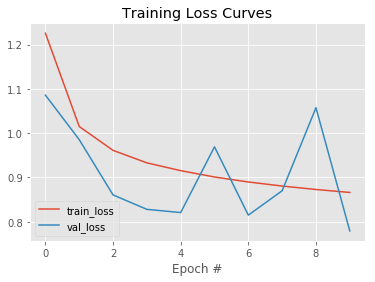

In [50]:
my_model_1.plot_loss()

It seems that we could train more epochs, as the loss is still reducing and the val_loss doesn't seem to be increasing. and therefore the model is not overfitting yet. So let's train some more epochs.

In [56]:
my_model_1.train(train_params, train_data_1, train_labels_1, eval_data_1, eval_labels_1, labels_1_weights, checkpoints=True)


Training model...
Train on 475000 samples, validate on 25000 samples
Epoch 1/10
475000/475000 [==============================] - 813s 2ms/step - loss: 0.8616 - weighted_categorical_accuracy: 0.6252 - val_loss: 0.9010 - val_weighted_categorical_accuracy: 0.6018

Epoch 00001: saving model to ./cp-0001.ckpt
Epoch 2/10
475000/475000 [==============================] - 847s 2ms/step - loss: 0.8546 - weighted_categorical_accuracy: 0.6282 - val_loss: 0.8245 - val_weighted_categorical_accuracy: 0.6376

Epoch 00002: saving model to ./cp-0002.ckpt
Epoch 3/10
475000/475000 [==============================] - 830s 2ms/step - loss: 0.8494 - weighted_categorical_accuracy: 0.6305 - val_loss: 0.8555 - val_weighted_categorical_accuracy: 0.6290

Epoch 00003: saving model to ./cp-0003.ckpt
Epoch 4/10
475000/475000 [==============================] - 806s 2ms/step - loss: 0.8451 - weighted_categorical_accuracy: 0.6325 - val_loss: 0.7715 - val_weighted_categorical_accuracy: 0.6693

Epoch 00004: saving model t

(0.6543263157543383, 0.8451820698738098, 0.6330000003242493, 8569.840616999998)

In [57]:
my_model_1.print_statistics()

Train accuracy [%]:  65.43263157543383
Eval accuracy [%]:  63.30000003242493
Bias [%]:  34.56736842456617
Variance [%]:  2.1326315430089005


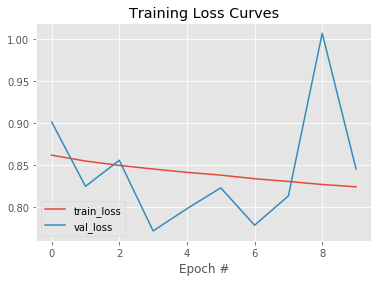

In [58]:
my_model_1.plot_loss()

We see that the val_loss is probably starting to increase, so the model is starting to overfit maybe (we have some noise that makes it difficult to know exactly though). We could try to improve this trining more epochs but using dropout. But for now we will keep the checkpoint with the best performance and continue with the rest of the task.

In [63]:
checkpoint_path = "./cp-0004.ckpt"
my_model_1.model.load_weights(checkpoint_path)

Now we will make predictions on dataset_3 (Text+Rating+Business.csv) to get some statistics

In [64]:
predictions_ratings_data_3 = my_model_1.model.predict(data_3, batch_size=train_params["BATCH_SIZE"], verbose=1)

3131/3131 [==============================] - 2s 573us/step


We load the real name of the business (instead of the id)

In [65]:
labels_3_names = sorted(text_and_business_hashtable, key=text_and_business_hashtable.get)

business_infos = []
for line in open('yelp_academic_dataset_business.json', 'r'):
    business_infos.append(json.loads(line))
real_labels_3_names = labels_3_names

for business_info in business_infos:
    for idx,labels_3_name in enumerate(labels_3_names):
        if business_info["business_id"]==labels_3_name:
            real_labels_3_names[idx]=business_info["name"]

And show the corresponding metrics for a multi-class classification problem

In [66]:
report = classification_report(y_true=ratings_3, y_pred=predictions_ratings_data_3.argmax(axis=1), labels=range(0,labels_1.shape[1]), output_dict=True)
df_report = pd.DataFrame(report)
metrics_cols = ['micro avg', 'macro avg', 'weighted avg']
df_report_by_review = df_report.drop(columns=metrics_cols, inplace=False).sort_values(by="f1-score", axis=1, ascending=False)
display(df_report_by_review)
df_report.to_csv("report_model_1_by_review.csv", encoding = 'utf-8')

/home/maxi/.virtualenvs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/maxi/.virtualenvs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,5,1,4,2,3,0
f1-score,0.764063,0.668954,0.568995,0.484848,0.460472,0.0
precision,0.775678,0.752896,0.539871,0.405530,0.566553,0.0
recall,0.752791,0.601852,0.601441,0.602740,0.387850,0.0
support,1254.000000,324.000000,833.000000,292.000000,428.000000,0.0


We see that the model classifies better the 5-star reviews than the 3-stars reviews.

In [67]:
all_cols = df_report.columns.values.tolist()
drop_cols = (set(all_cols)-set(metrics_cols))
df_report_by_metrics = df_report.drop(columns=drop_cols, inplace=False)
display(df_report_by_metrics)
df_report.to_csv("report_model_1_by_metrics.csv", encoding = 'utf-8')

,macro avg,micro avg,weighted avg
f1-score,0.491222,0.633025,0.634783
precision,0.506755,0.633025,0.647477
recall,0.491112,0.633025,0.633025
support,3131.000000,3131.000000,3131.000000


Finally, we will make the inferences of the ratings/stars of the texts from MyExperiences.csv. We will be reading this file in chunks, as it is too large (and unnecessary) to open it completely. But we can increase the batch_size for the inference process, as it uses less memory than the training process.

In [71]:
chunksize = 10 ** 5
for chunk in pd.read_csv("MyExperiences.csv", usecols=["review_id","text"], chunksize=chunksize):
    texts = chunk["text"].values
    sequences = tokenizer.texts_to_sequences(texts)
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    chunk_predictions = my_model_1.model.predict(data, batch_size=4*train_params["BATCH_SIZE"], verbose=1)
    chunk["stars"] = np.argmax(chunk_predictions, axis=1)
    chunk.to_csv("./MyExperiences_ratings.csv", mode='a')

 28672/100000 [=======>......................] - ETA: 23s

KeyboardInterrupt: 

(I stopped the last cell just because it takes too much time)

### Model 2 (business output)

For this model we will train with k-folds cross-validatoin, as the dataset is smaller, and therefore more prone to overfit to test-set.

In [72]:
train_params = {
    "BATCH_SIZE": 512,
    "NUM_EPOCHS": 5
}
k_folds = 5

#### 1st set of hyperparams

In [73]:
list_of_hyperparams = [
                    {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 64,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 16,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_2.shape[1]
                    },
                    {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 64,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 32,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_2.shape[1]
                    },
                    {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 128,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 32,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_2.shape[1]
                    },
                    {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 256,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 64,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_2.shape[1]
                    }
                ]

In [77]:
tuning_step = MyTuningStep()
tuning_step.train_tuning_step_with_kfolds(train_params=train_params, list_of_hyperparams=list_of_hyperparams, data=data_2, labels=labels_2, labels_weights=labels_2_weights, k_folds=k_folds)

MODEL:  0
FOLD:  0
Training model...
Train on 39038 samples, validate on 9812 samples
Epoch 1/5
39038/39038 [==============================] - 52s 1ms/step - loss: 4.4662 - weighted_categorical_accuracy: 0.0273 - val_loss: 4.3261 - val_weighted_categorical_accuracy: 0.0388
Epoch 2/5
39038/39038 [==============================] - 48s 1ms/step - loss: 4.0648 - weighted_categorical_accuracy: 0.0815 - val_loss: 4.0100 - val_weighted_categorical_accuracy: 0.0754
Epoch 3/5
39038/39038 [==============================] - 48s 1ms/step - loss: 3.7226 - weighted_categorical_accuracy: 0.1483 - val_loss: 3.6259 - val_weighted_categorical_accuracy: 0.1478
Epoch 4/5
39038/39038 [==============================] - 48s 1ms/step - loss: 3.4094 - weighted_categorical_accuracy: 0.1958 - val_loss: 3.3947 - val_weighted_categorical_accuracy: 0.1779
Epoch 5/5
39038/39038 [==============================] - 48s 1ms/step - loss: 3.1457 - weighted_categorical_accuracy: 0.2392 - val_loss: 3.1840 - val_weighted_cat

9788/9788 [==============================] - 4s 418us/step
FOLD:  2
Training model...
Train on 39075 samples, validate on 9775 samples
Epoch 1/5
39075/39075 [==============================] - 48s 1ms/step - loss: 4.4871 - weighted_categorical_accuracy: 0.0332 - val_loss: 4.3524 - val_weighted_categorical_accuracy: 0.0433
Epoch 2/5
39075/39075 [==============================] - 46s 1ms/step - loss: 3.9489 - weighted_categorical_accuracy: 0.0929 - val_loss: 4.0546 - val_weighted_categorical_accuracy: 0.0698
Epoch 3/5
39075/39075 [==============================] - 46s 1ms/step - loss: 3.5255 - weighted_categorical_accuracy: 0.1587 - val_loss: 3.4333 - val_weighted_categorical_accuracy: 0.1531
Epoch 4/5
39075/39075 [==============================] - 46s 1ms/step - loss: 3.1621 - weighted_categorical_accuracy: 0.2321 - val_loss: 3.2579 - val_weighted_categorical_accuracy: 0.1821
Epoch 5/5
39075/39075 [==============================] - 46s 1ms/step - loss: 2.8708 - weighted_categorical_accur

Time spent: [s]: 350
Evaluating model...
9749/9749 [==============================] - 4s 431us/step
FOLD:  4
Training model...
Train on 39124 samples, validate on 9726 samples
Epoch 1/5
39124/39124 [==============================] - 49s 1ms/step - loss: 4.4005 - weighted_categorical_accuracy: 0.0396 - val_loss: 4.1591 - val_weighted_categorical_accuracy: 0.0632
Epoch 2/5
39124/39124 [==============================] - 49s 1ms/step - loss: 3.8244 - weighted_categorical_accuracy: 0.1156 - val_loss: 3.7091 - val_weighted_categorical_accuracy: 0.1203
Epoch 3/5
39124/39124 [==============================] - 48s 1ms/step - loss: 3.4048 - weighted_categorical_accuracy: 0.1903 - val_loss: 3.4195 - val_weighted_categorical_accuracy: 0.1717
Epoch 4/5
39124/39124 [==============================] - 48s 1ms/step - loss: 3.0300 - weighted_categorical_accuracy: 0.2650 - val_loss: 3.2786 - val_weighted_categorical_accuracy: 0.1928
Epoch 5/5
39124/39124 [==============================] - 48s 1ms/step - 

(array([0.21454258, 0.26815721, 0.29769311, 0.36750228]),
 array([3.26383438, 2.98318697, 2.86056535, 2.60486161]),
 array([0.20426393, 0.25320009, 0.27769951, 0.33937573]),
 array([351.0089686, 342.4711168, 349.0196766, 348.5920672]))

In [79]:
tuning_step.print_statistics()

Train accuracy [%]:  [21.45425816 26.81572141 29.76931081 36.75022803]
Eval accuracy [%]:  [20.42639276 25.32000942 27.769951   33.93757293]
Bias [%]:  [78.54574184 73.18427859 70.23068919 63.24977197]
Variance [%]:  [1.0278654  1.49571199 1.99935981 2.8126551 ]


#### 2st set of hyperparams
So the best configuration was the set 3, which is the most complex one. So let's try some more complex  sets similar to that one, to see what happens.

In [80]:
list_of_hyperparams = [
                {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 512,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 256,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_2.shape[1]
                    },
                {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 1024,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 512,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_2.shape[1]
                    },
                {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 2048,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 1024,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_2.shape[1]
                    },
                {
                    "LSTM_DROPOUT" : 0,
                    "LSTM_RECURRENT_DROPOUT" : 0,
                    "1_FC_SIZE" : 1024,
                    "1_FC_DROPOUT" : 0,
                    "2_FC_SIZE" : 1024,
                    "2_FC_DROPOUT" : 0,
                    "FINAL_SIZE" : labels_2.shape[1]
                    },
                ]

In [81]:
tuning_step.train_tuning_step_with_kfolds(train_params=train_params, list_of_hyperparams=list_of_hyperparams, data=data_2, labels=labels_2, labels_weights=labels_2_weights, k_folds=k_folds)

MODEL:  0
FOLD:  0
Training model...
Train on 39038 samples, validate on 9812 samples
Epoch 1/5
39038/39038 [==============================] - 51s 1ms/step - loss: 3.7904 - weighted_categorical_accuracy: 0.1314 - val_loss: 3.4212 - val_weighted_categorical_accuracy: 0.1689
Epoch 2/5
39038/39038 [==============================] - 49s 1ms/step - loss: 2.6707 - weighted_categorical_accuracy: 0.3286 - val_loss: 2.8791 - val_weighted_categorical_accuracy: 0.2815
Epoch 3/5
39038/39038 [==============================] - 49s 1ms/step - loss: 2.2446 - weighted_categorical_accuracy: 0.4184 - val_loss: 2.5582 - val_weighted_categorical_accuracy: 0.3492
Epoch 4/5
39038/39038 [==============================] - 49s 1ms/step - loss: 2.0138 - weighted_categorical_accuracy: 0.4716 - val_loss: 2.4088 - val_weighted_categorical_accuracy: 0.3823
Epoch 5/5
39038/39038 [==============================] - 49s 1ms/step - loss: 1.8616 - weighted_categorical_accuracy: 0.5063 - val_loss: 2.2986 - val_weighted_cat

9788/9788 [==============================] - 4s 432us/step
FOLD:  2
Training model...
Train on 39075 samples, validate on 9775 samples
Epoch 1/5
39075/39075 [==============================] - 55s 1ms/step - loss: 3.5492 - weighted_categorical_accuracy: 0.1719 - val_loss: 3.3181 - val_weighted_categorical_accuracy: 0.2160
Epoch 2/5
39075/39075 [==============================] - 49s 1ms/step - loss: 2.4048 - weighted_categorical_accuracy: 0.3805 - val_loss: 2.8384 - val_weighted_categorical_accuracy: 0.3011
Epoch 3/5
39075/39075 [==============================] - 49s 1ms/step - loss: 2.0309 - weighted_categorical_accuracy: 0.4662 - val_loss: 2.6163 - val_weighted_categorical_accuracy: 0.3431
Epoch 4/5
39075/39075 [==============================] - 49s 1ms/step - loss: 1.8251 - weighted_categorical_accuracy: 0.5171 - val_loss: 2.4118 - val_weighted_categorical_accuracy: 0.3863
Epoch 5/5
39075/39075 [==============================] - 49s 1ms/step - loss: 1.6884 - weighted_categorical_accur

Time spent: [s]: 381
Evaluating model...
9749/9749 [==============================] - 5s 490us/step
FOLD:  4
Training model...
Train on 39124 samples, validate on 9726 samples
Epoch 1/5
39124/39124 [==============================] - 61s 2ms/step - loss: 3.3350 - weighted_categorical_accuracy: 0.2137 - val_loss: 3.0164 - val_weighted_categorical_accuracy: 0.2626
Epoch 2/5
39124/39124 [==============================] - 50s 1ms/step - loss: 2.2654 - weighted_categorical_accuracy: 0.4122 - val_loss: 2.7240 - val_weighted_categorical_accuracy: 0.3293
Epoch 3/5
39124/39124 [==============================] - 51s 1ms/step - loss: 1.9288 - weighted_categorical_accuracy: 0.4890 - val_loss: 2.4415 - val_weighted_categorical_accuracy: 0.3782
Epoch 4/5
39124/39124 [==============================] - 50s 1ms/step - loss: 1.7159 - weighted_categorical_accuracy: 0.5410 - val_loss: 2.6218 - val_weighted_categorical_accuracy: 0.3451
Epoch 5/5
39124/39124 [==============================] - 50s 1ms/step - 

(array([0.46531162, 0.48588869, 0.4682105 , 0.46656374]),
 array([2.30505046, 2.35713613, 2.47741552, 2.52307179]),
 array([0.40796605, 0.40452501, 0.3759766 , 0.37341348]),
 array([349.5790434, 344.8153834, 365.3953644, 354.5131678]))

In [83]:
tuning_step.print_statistics()

Train accuracy [%]:  [46.53116224 48.58886913 46.82104984 46.65637443]
Eval accuracy [%]:  [40.79660495 40.45250121 37.5976603  37.34134795]
Bias [%]:  [53.46883776 51.41113087 53.17895016 53.34362557]
Variance [%]:  [5.73455729 8.13636792 9.22338954 9.31502648]


#### Final set of hyperparams
So the set 1 is the one with the lower Bias, but it also has some variance. We could keep looking for better hyperparameters, but just to keep on to finish the challenge before the deadline, let's keep with this values, but training more epochs and adding some dropout to reduce variance.

In [84]:
hyperparams =       {
                    "LSTM_DROPOUT" : 0.1,
                    "LSTM_RECURRENT_DROPOUT" : 0.1,
                    "1_FC_SIZE" : 1024,
                    "1_FC_DROPOUT" : 0.5,
                    "2_FC_SIZE" : 512,
                    "2_FC_DROPOUT" : 0.5,
                    "FINAL_SIZE" : labels_2.shape[1]
                    }

train_params = {
    "BATCH_SIZE": 1024,
    "NUM_EPOCHS": 20
}
val_split = 0.1

In [85]:
train_data_2, eval_data_2, train_labels_2, eval_labels_2 = train_test_split(data_2, labels_2, test_size=val_split, random_state=456, stratify=np.argmax(labels_2, axis=1))

tuning_step.reset_keras()

my_model_2 = MyModel(hyperparams)
my_model_2.train(train_params, train_data_2, train_labels_2, eval_data_2, eval_labels_2, labels_2_weights, checkpoints=True)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fa5cccb31d0>>
Traceback (most recent call last):
  File "/home/maxi/.virtualenvs/py3/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/maxi/.virtualenvs/py3/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fa5cb236ba8>>
Traceback (most recent call last):
  File "/home/maxi/.virtualenvs/py3/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/maxi/.virt

Training model...
Train on 43965 samples, validate on 4885 samples
Epoch 1/20
43965/43965 [==============================] - 105s 2ms/step - loss: 5.1963 - weighted_categorical_accuracy: 0.0293 - val_loss: 3.9910 - val_weighted_categorical_accuracy: 0.0817

Epoch 00001: saving model to ./cp-0001.ckpt
Epoch 2/20
43965/43965 [==============================] - 102s 2ms/step - loss: 4.3002 - weighted_categorical_accuracy: 0.0801 - val_loss: 3.3475 - val_weighted_categorical_accuracy: 0.1713

Epoch 00002: saving model to ./cp-0002.ckpt
Epoch 3/20
43965/43965 [==============================] - 102s 2ms/step - loss: 3.6437 - weighted_categorical_accuracy: 0.1480 - val_loss: 2.9977 - val_weighted_categorical_accuracy: 0.2532

Epoch 00003: saving model to ./cp-0003.ckpt
Epoch 4/20
43965/43965 [==============================] - 106s 2ms/step - loss: 3.2389 - weighted_categorical_accuracy: 0.2049 - val_loss: 2.7574 - val_weighted_categorical_accuracy: 0.3034

Epoch 00004: saving model to ./cp-000

(0.5232116455119664, 1.9067255150210285, 0.4929375664116538, 2134.975222000001)

In [86]:
my_model_2.print_statistics()

Train accuracy [%]:  52.321164551196645
Eval accuracy [%]:  49.29375664116538
Bias [%]:  47.678835448803355
Variance [%]:  3.0274079100312656


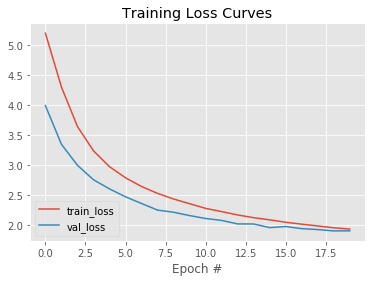

In [87]:
my_model_2.plot_loss()

We see that the model is fitting ok, so we could still try training more epochs. But for now we will continue with the rest of the task.

Now we will make predictions on dataset_3 (Text+Rating+Business.csv) to get some statistics

In [90]:
predictions_business_data_3 = my_model_2.model.predict(data_3, batch_size=train_params["BATCH_SIZE"], verbose=1)

3131/3131 [==============================] - 2s 722us/step


In [106]:
pd.set_option('display.max_columns', 999)

In [107]:
report = classification_report(y_true=[text_and_business_hashtable.get(elem) for elem in business_3], y_pred=predictions_business_data_3.argmax(axis=1), labels=range(0,labels_2.shape[1]), target_names=real_labels_3_names, output_dict=True)
df_report = pd.DataFrame(report)
metrics_cols = ['micro avg', 'macro avg', 'weighted avg']
df_report_by_review = df_report.drop(columns=metrics_cols, inplace=False).sort_values(by="f1-score", axis=1, ascending=False)

df_report.to_csv("report_model_2_by_review.csv", encoding = 'utf-8')
df_report_by_review

,Schwartz’s,Little Miss BBQ,Yama Sushi,Lux Central,Lotus of Siam,Bouchon at the Venezia Tower,Bobby Q,Pampas Churrascaria Brazilian Grille,Mesa Grill,Yardbird Southern Table & Bar,Pizzeria Bianco,Pai Northern Thai Kitchen,Gordon Ramsay BurGR,Rehab Burger Therapy,Golden Nugget,The Mirage,Firefly,Bachi Burger,Bellagio Hotel,Joe's Farm Grill,Luxor Hotel and Casino Las Vegas,Cibo,Monte Carlo Hotel And Casino,Rio All Suites Hotel & Casino,Gordon Ramsay Pub & Grill,Hard Rock Hotel & Casino,Marquee Nightclub & Dayclub,ARIA Resort & Casino,El Dorado Cantina,Giada,Carson Kitchen,Wynn Las Vegas,Spice Market Buffet,Studio B Buffet,The Peppermill Restaurant & Fireside Lounge,Excalibur Hotel,Hash House A Go Go,SkinnyFATS,The Venetian Las Vegas,HEXX kitchen + bar,The Buffet,OTHERS,"SLS Las Vegas, A Tribute Portfolio Resort",Shake Shack,Wicked Spoon,SUSHISAMBA - Las Vegas,Rollin Smoke Barbeque,XS Nightclub,Secret Pizza,Vdara Hotel,Serendipity 3,The Palazzo Las Vegas,Treasure Island,Stratosphere,The Oyster Bar,TAO Nightclub,Tom Colicchio's Craftsteak,Tacos El Gordo,The Arrogant Butcher,The Buffet at ARIA,The Buffet at Bellagio,The Cosmopolitan of Las Vegas,The LINQ Hotel & Casino,Planet Hollywood Las Vegas Resort & Casino,Circus Circus Las Vegas Hotel and Casino,Pizza Rock,Four Peaks Brewing,High Roller,Hakkasan Nightclub,Guy Fieri's Vegas Kitchen & Bar,Grand Lux Cafe,Gordon Ramsay Steak,Gangnam Asian BBQ Dining,Flamingo Las Vegas Hotel & Casino,Joes Seafood Prime Steak & Stone Crab,Encore,"Ellis Island Hotel, Casino & Brewery",Egg & I,Echo & Rig,Eat.,Earl of Sandwich,Holsteins Shakes & Buns,KA by Cirque Du Soleil,Phoenix Sky Harbor International Airport,Monta Ramen,Pho Kim Long,Paris Las Vegas Hotel & Casino,Burger Bar,Olives,Cirque du Soleil - The Beatles LOVE,Mr Mamas,Mon Ami Gabi,La Santisima,Bacchanal Buffet,McCarran International Airport,Mandalay Bay Resort & Casino,MGM Grand Hotel,Caesars Palace Las Vegas Hotel & Casino,Le Village Buffet,New York New York Hotel & Casino
f1-score,0.912281,0.817204,0.792453,0.747475,0.729167,0.723404,0.718447,0.713043,0.692308,0.682540,0.666667,0.659091,0.611111,0.605263,0.595745,0.595238,0.589474,0.577465,0.564885,0.559140,0.558824,0.547945,0.536082,0.535211,0.530612,0.527273,0.515152,0.509804,0.507692,0.496124,0.493151,0.464000,0.455285,0.450704,0.431034,0.416107,0.416000,0.406780,0.403361,0.323810,0.318182,0.019672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precision,0.928571,0.760000,0.750000,0.755102,0.921053,0.850000,0.902439,0.872340,0.833333,0.826923,0.723404,0.674419,0.733333,0.500000,0.622222,0.862069,0.538462,0.694915,0.685185,0.742857,0.808511,0.666667,0.866667,0.826087,0.812500,0.674419,0.894737,0.847826,0.412500,0.680851,0.750000,0.500000,0.368421,1.000000,0.555556,0.424658,0.838710,0.393443,0.800000,0.333333,0.700000,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recall,0.896552,0.883721,0.840000,0.740000,0.603448,0.629630,0.596774,0.602941,0.592105,0.581081,0.618182,0.644444,0.523810,0.766667,0.571429,0.454545,0.651163,0.493976,0.480519,0.448276,0.426966,0.465116,0.388060,0.395833,0.393939,0.432836,0.361702,0.364486,0.660000,0.390244,0.367347,0.432836,0.595745,0.290909,0.352113,0.407895,0.276596,0.421053,0.269663,0.314815,0.205882,0.010204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
support,58.000000,43.000000,50.000000,50.000000,116.000000,108.000000,62.000000,68.000000,76.000000,74.000000,55.000000,45.000000,147.000000,60.0000

We see that the model classifies better Schwartz's reviews than the The Buffet reviews. So we could use the first X columns of this table to, answering one of the challenge's tasks, provide value to some of the companies in the dataset.

In [101]:
all_cols = df_report.columns.values.tolist()
drop_cols = (set(all_cols)-set(metrics_cols))
df_report_by_metrics = df_report.drop(columns=drop_cols, inplace=False)
display(df_report_by_metrics)
df_report.to_csv("report_model_2_by_metrics.csv", encoding = 'utf-8')

,macro avg,micro avg,weighted avg
f1-score,0.231834,0.446503,0.515073
precision,0.293111,0.446503,0.687406
recall,0.206371,0.446503,0.446503
support,3131.000000,3131.000000,3131.000000


Finally, we will make the inferences of the comapies of the texts from MyExperiences.csv. We will be reading this file in chunks, as it is too large (and unnecessary) to open it completely. But we can increase the batch_size for the inference process, as it uses less memory than the training process.

In [120]:
chunksize = 10 ** 5
business_ids = np.array(sorted(text_and_business_hashtable, key=text_and_business_hashtable.get))
for chunk in pd.read_csv("MyExperiences.csv", usecols=["review_id","text"], chunksize=chunksize):
    texts = chunk["text"].values
    sequences = tokenizer.texts_to_sequences(texts)
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    chunk_predictions = my_model_2.model.predict(data, batch_size=2*train_params["BATCH_SIZE"], verbose=1)
    chunk["business_id"] = business_ids[np.argmax(chunk_predictions, axis=1)]
    chunk.to_csv("./MyExperiences_business.csv", mode='a')

 69632/100000 [===================>..........] - ETA: 12s

KeyboardInterrupt: 

(I stopped the last cell just because it takes too much time)